##Build a Multi-Ouput Model

This code will demonstrate how to build a multi-ouput model. The dataset that will be used to train and test the model is an Energy Efficiancy dataset that uses building features (wall area, roof area, etc.) as inputs and has two outputs: Cooling Load and Heating Load

##Imports

In [97]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

##Utilities

Used for data conversion and visualization

In [98]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

##Prep the Data

In [99]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)


##Build the Model 

Use functional syntax

Notice the ability to specify a list of outputs (ie `[y1_output, y2_output`) when instantiating the `Model()` class

In [100]:
#Define model layers 
input_layer = tf.keras.layers.Input(shape=(len(train.columns)), name='input_1')
first_dense = tf.keras.layers.Dense(units='128', activation='relu', name='dense_1')(input_layer)
second_dense = tf.keras.layers.Dense(units='128', activation='relu', name='dense_2')(first_dense)
third_dense = tf.keras.layers.Dense(units='64', activation='relu', name='dense_3')(second_dense)

#Y1 output will be fed directly from the second_dense
y1_output = tf.keras.layers.Dense(units='1', name='y1_output')(second_dense)

#Y2 ouput will be fed directly from the third_dense
y2_output = tf.keras.layers.Dense(units='1', name='y2_output')(third_dense)

In [101]:
#Define the model with the input layer and a list of output layers 
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 128)          16512       ['dense_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 64)           8256        ['dense_2[0][0]']                
                                                                                            

##Plot the model

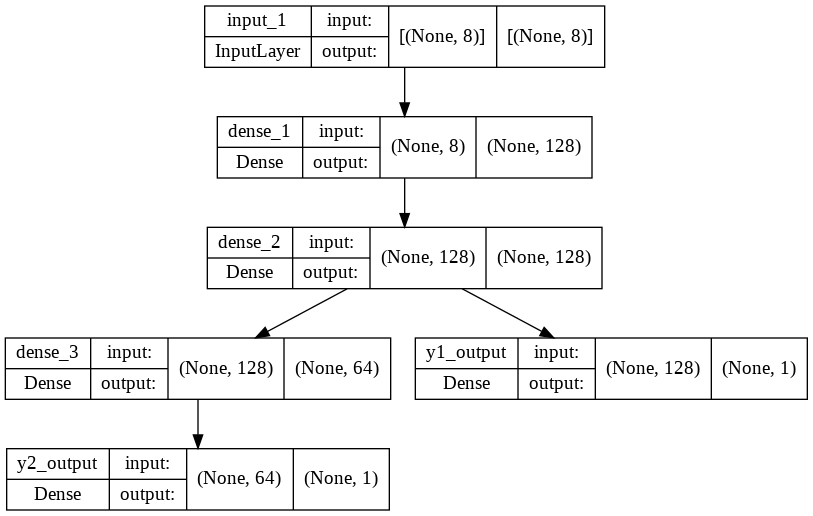

In [102]:
img_file = './model.png'

plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

##Configure the parameters 

Specify the optimizer as well as the loss and metrics for each input 

In [103]:
#Specify the optimizer and compile the modle with Loss functions for both outputs 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

#Set training parameters 
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse',
                    'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

##Train the model

In [104]:
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 3s 23ms/step - loss: 249.6204 - y1_output_loss: 113.8845 - y2_output_loss: 135.7360 - y1_output_root_mean_squared_error: 10.6717 - y2_output_root_mean_squared_error: 11.6506 - val_loss: 45.6125 - val_y1_output_loss: 16.6490 - val_y2_output_loss: 28.9635 - val_y1_output_root_mean_squared_error: 4.0803 - val_y2_output_root_mean_squared_error: 5.3818
Epoch 2/500
62/62 [==============================] - 1s 10ms/step - loss: 29.5642 - y1_output_loss: 12.5383 - y2_output_loss: 17.0258 - y1_output_root_mean_squared_error: 3.5410 - y2_output_root_mean_squared_error: 4.1262 - val_loss: 29.0806 - val_y1_output_loss: 11.3027 - val_y2_output_loss: 17.7779 - val_y1_output_root_mean_squared_error: 3.3619 - val_y2_output_root_mean_squared_error: 4.2164
Epoch 3/500
62/62 [==============================] - 0s 8ms/step - loss: 24.5213 - y1_output_loss: 10.3774 - y2_output_loss: 14.1440 - y1_output_root_mean_squared_error: 3.2214 - y2_output_root_mean_

##Evaluate and Plot Metrics 

In [105]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 0.7387 - y1_output_loss: 0.1691 - y2_output_loss: 0.5696 - y1_output_root_mean_squared_error: 0.4112 - y2_output_root_mean_squared_error: 0.7547
Loss = 0.738652765750885, Y1_loss = 0.1690598428249359, Y1_mse = 0.4111688435077667, Y2_loss = 0.5695928931236267, Y2_mse = 0.754713773727417


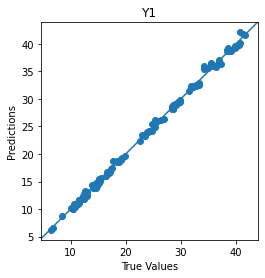

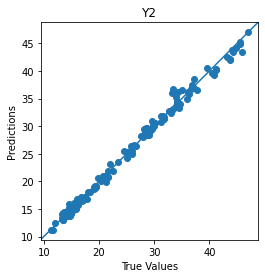

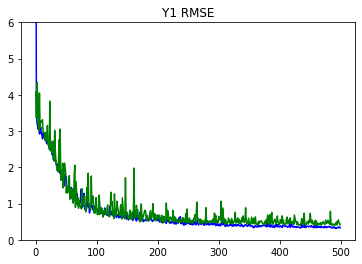

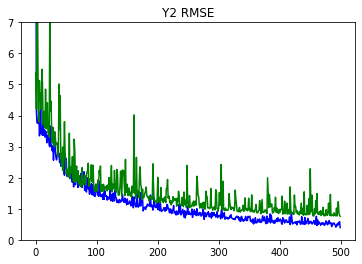

In [106]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)
